# Loading the Dataset

In [3]:
import nltk
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
from gensim.models import KeyedVectors

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()

2024-05-14 14:14:10.086988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 14:14:10.087089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 14:14:10.223668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
movies_details_df = pd.read_json('/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json', lines=True)
display(movies_details_df.head())

reviews_df = pd.read_json('/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
display(reviews_df.head())

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


# Presentation of the Dataset

In [ ]:
#TODO

# Preprocessing

## Tokenizer with regular expressions

In [23]:
imdb_spoilers_list = list(movies_details_df['plot_synopsis']) \
                    + list(movies_details_df['plot_summary']) \
                    + list(reviews_df['review_summary']) \
                    + list(reviews_df['review_text'])

imdb_spoilers_strings = " ".join(imdb_spoilers_list)

In [ ]:
# Have to reduce cause the len of `imdb_spoilers_strings` is 872 920 167 which way too big for my PC to tokenize (I might use Spark)
imdb_spoilers_strings_reduced = imdb_spoilers_strings[:1000000]
imdb_spoilers_tokens = word_tokenize(imdb_spoilers_strings_reduced)

## Tokenizer with BPE

In [ ]:
enc = tiktoken.encoding_for_model("gpt-4")
imdb_spoilers_tokens_bpe = enc.encode(imdb_spoilers_strings_reduced)

## Normalisation

### Deleting the stopwords && put in lowercase the words

In [ ]:
stop_words = set(stopwords.words('english'))
imdb_spoilers_tokens = [w.lower() for w in imdb_spoilers_tokens if not w.lower() in stop_words]

### Lemmatization : Changes the word to their inflected form (sleeping -> sleep)

In [ ]:
lemmatizer = WordNetLemmatizer()
imdb_spoilers_tokens = [lemmatizer.lemmatize(w) for w in imdb_spoilers_tokens]

# Descriptive statistics

# Training on several predictive models

## Setup the dataFrame for the predictive models

Which part contains spoilers ?

1. Plot summary : Does not contain spoiler
2. Plot synopsis: Contains Spoiler

In [18]:
# Cleaning the plot_synopsis column
plot_synopsis = movies_details_df.loc[movies_details_df['plot_synopsis'] != '', 'plot_synopsis']

# Outputs the length of the 2 category
no_spoil_length = len(movies_details_df['plot_summary'])
spoil_length = len(plot_synopsis)

# Create the appropriate dataFrame for ours models : Text - Is Spoil
all_texts = pd.concat([movies_details_df['plot_summary'], plot_synopsis])
spoil_categories = [0] * no_spoil_length + [1] * spoil_length
is_spoiler_df = pd.DataFrame({'text': all_texts, 'is_spoiler': spoil_categories})

# Clean the reviews df to make it more appropriate
reviews_df = reviews_df[['review_text', 'is_spoiler']]
reviews_df = reviews_df.rename(columns={'review_text': 'text'})

# Concat the two df
is_spoiler_df = pd.concat([reviews_df, is_spoiler_df], axis=0, ignore_index=True)

is_spoiler_df

,text,is_spoiler
0,"In its Oscar year, Shawshank Redemption (writt...",1
1,The Shawshank Redemption is without a doubt on...,1
2,I believe that this film is the best story eve...,1
3,"**Yes, there are SPOILERS here**This film has ...",1
4,At the heart of this extraordinary movie is a ...,1
...,...,...
576819,The film opens with a homeless man (Bud Cort) ...,1
576820,Will Freeman (Hugh Grant) is a 38-year-old bac...,1
576821,"In the year 1998, Evan Treborn (Ashton Kutcher...",1
576822,"Brandon (Michael Fassbender) is a successful, ...",1


In [ ]:
wv =  KeyedVectors.load('/kaggle/input/word2vec/word2vec.wordvectors', mmap='r')
spoil = wv.most_similar("spoil", topn=40)
spoiler = wv.most_similar("spoiler", topn=40)
spoiler_list = [word for word, _ in spoil] + [word for word, _ in spoiler]

def count_spoil_words(string):
    count = 0
    for word in string.split():
        if word in spoiler_list:
            count += 1    
    return count

is_spoiler_df['count_spoil'] = is_spoiler_df['text'].progress_apply(count_spoil_words)

In [19]:
X = is_spoiler_df['text']
y = is_spoiler_df['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
test_spoilers = [
    "Lyes dies at the end.",
    "Bruce Willis was dead all along in 'The Sixth Sense' ! What a revelation !",
    "In the end of stars Wars, it is revealed that Darth Vader was Luke's father !",
    "Hank's death at the end of 'Breaking Bad' was so unexpected. I was completely shocked.",
    "Verbal Kint is actually Keyser Söze in 'The Usual Suspects'! BIG PLOT TWIST"
]

def testsuite(model, test_spoilers):
    for spoiler in test_spoilers:
        print(f"{spoiler} --> Spoiler : { model.predict([spoiler])}")

## Naive Bayesian Model

In [ ]:
model = make_pipeline(CountVectorizer(stop_words='english'), MultinomialNB())

cross_val_predict(model, X_train, y_train, cv=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     84677
           1       0.52      0.46      0.49     30688

    accuracy                           0.74    115365
   macro avg       0.67      0.65      0.66    115365
weighted avg       0.74      0.74      0.74    115365



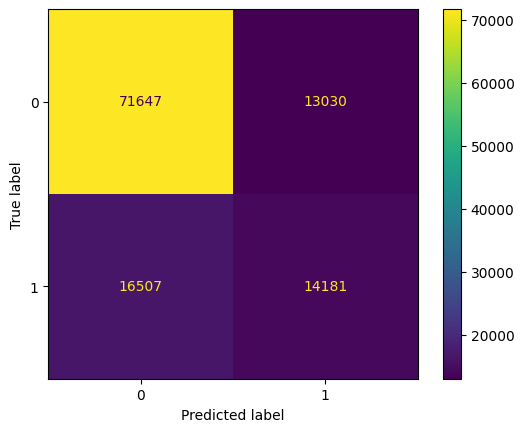

In [24]:
report = classification_report(y_test, y_pred, labels=model.classes_, output_dict=True)
print(classification_report(y_test, y_pred, labels=model.classes_))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## Logistic Regression

In [ ]:
model = make_pipeline(TfidfVectorizer(stop_words="english"), LogisticRegression(random_state=42, class_weight="balanced", C=1, solver='liblinear' max_iter = 100))

cross_val_predict(model, X_train, y_train, cv=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [17]:
report = classification_report(y_test, y_pred, labels=model.classes_, output_dict=True)
print(classification_report(y_test, y_pred, labels=model.classes_))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

AttributeError: 'Sequential' object has no attribute 'classes_'

In [ ]:
testsuite(model,test_spoilers)

Lyes dies at the end. --> Spoiler : [ True]



Bruce Willis was dead all along in 'The Sixth Sense' ! What a revelation ! --> Spoiler : [False]



In the end of stars Wars, it is revealed that Darth Vader was Luke's father ! --> Spoiler : [ True]



Hank's death at the end of 'Breaking Bad' was so unexpected. I was completely shocked. --> Spoiler : [ True]



Verbal Kint is actually Keyser Söze in 'The Usual Suspects'! BIG PLOT TWIST --> Spoiler : [ True]


## Feedforward Neural Network

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=1000)
X_val_pad = pad_sequences(X_val_seq, maxlen=1000)

In [34]:
weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

model = Sequential([
    layers.Embedding(len(tokenizer.word_index) + 1, 64, input_length=1000),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

#model.layers[0].adapt(X_train)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train.values, epochs=3, batch_size=32, class_weight=dict(enumerate(weight)), validation_data=(X_val_pad, y_test.values))

Epoch 1/3

14421/14421 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - accuracy: 0.6661 - loss: 0.6128 - val_accuracy: 0.7341 - val_loss: 0.5633

Epoch 2/3

14421/14421 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.7489 - loss: 0.5165 - val_accuracy: 0.7037 - val_loss: 0.5562

Epoch 3/3

14421/14421 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.8239 - loss: 0.3858 - val_accuracy: 0.7398 - val_loss: 0.5574


3606/3606 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


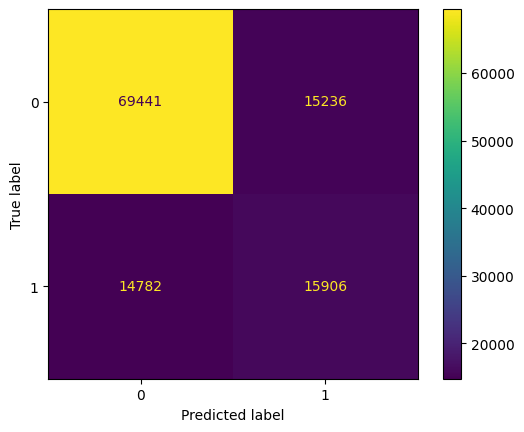

In [35]:
y_pred = (model.predict(X_val_pad) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [36]:
for spoiler in test_spoilers:
  print(f"{spoiler} --> Spoiler : { model.predict([[spoiler]])> 0.5 }")

NameError: name 'test_spoilers' is not defined